In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

url = "./data_labels_mainData.csv"
lm = pd.read_csv(url, header=0, sep=",")

url = "./data_labels_extraData.csv"
labelsExtra = pd.read_csv(url, header = 0, sep = ",")

#c/download/mlass2
#im guessing all images are 27x27

In [72]:
lm.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [73]:
lm.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [74]:
print(lm.groupby("patientID").sum())

           InstanceID  cellType  isCancerous
patientID                                   
1              425874        12            0
2              628686        39            0
3             2568206       103            0
4             2369214       102            0
5               37488       191           35
6              829447       219           28
7             2305050       224           61
8             1606974       615          282
9             2738401       388          148
10            4080377       392          155
11            1139240        37            0
12            2051207       116            0
13             820325       355          156
14             641900       311          140
15            2190657        74            0
16            2037271        64            0
17            2729966       618          261
18            2709587       623          290
19             176308       354           48
20             159572       683          220
21        

In [75]:
print(lm.groupby("cellTypeName").sum())

              InstanceID  patientID  cellType  isCancerous
cellTypeName                                              
epithelial      27445916     121296      8158         4079
fibroblast      24541213      55725         0            0
inflammatory    31935645      69164      2543            0
others          16955864      48340      4158            0


In [76]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(lm, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(lm, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 7422, Val Data: 2474, Test Data: 1980


In [77]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [78]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.12.0'

Building the neural network requires configuring the layers of the model, then compiling the model and finally training the model.

### Set up the layers
The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most neural networks consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

A layer in the MLP is represented by `tf.keras.layers.Dense`. First lets define the dimensions of our neural network.

There are three ways to build a model in tensorflow: 
 - Functional API
 - Sub-classing
 - Sequential API

We will use the `Sequential` API to build models as it is the simplest.


In [79]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 32 by 32 pixels) to a one-dimensional array (of 32 * 32 * 3 = 3072 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected (MLP), neural layers. The first Dense layer has 256 nodes (or neurons). The second (and last) layer returns a logits array with length of 4. Each node contains a score that indicates the current image belongs to one of the 4 classes.

We can use `model.summary()` to print the model that was created.

In [80]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2187)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               560128    
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [81]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- **Loss function**: This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- **Optimizer**: This is how the model is updated based on the data it sees and its loss function.
- **Metrics**: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


In [82]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [83]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

C:\Users\rodri\AppData\Local\Temp/ipykernel_21976/3169660569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cellType'] = train_data['cellType'].astype('str')
C:\Users\rodri\AppData\Local\Temp/ipykernel_21976/3169660569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['cellType'] = val_data['cellType'].astype('str')


In [84]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7422 validated image filenames belonging to 4 classes.
Found 2474 validated image filenames belonging to 4 classes.


In [85]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

C:\Users\rodri\AppData\Local\Temp/ipykernel_21976/2779164914.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


In [86]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

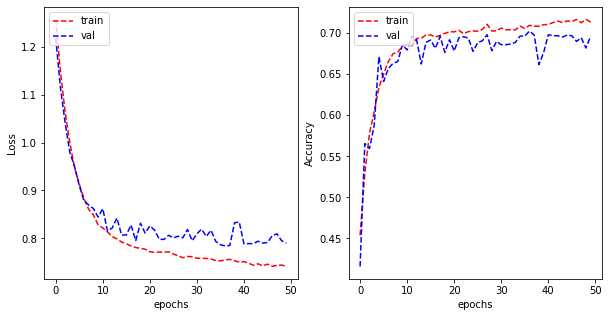

In [87]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Now you know how to setup a neural network and train it in tensorflow.

### Incremental changes
Next step is doing the incremental updates to improve the performance. Observe the loss curves and act accordingly. Some options are.

**If the model is under fitting:** 
1. Increase the number of neurones in the hidden layer 
2. Increase the number of hidden layers

**If the model is over fitting:**
1. Add regulatization: Lasso/Ridge penalty
2. Add dropout
3. Reduce number of neurones in each layer or number of layers.

Some of the steps are done in the LectureQandA code for week 9 module - neural networks. You can get the basic syntax from there and implement accordingly.


> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Tune the neural network model to get the best performance possible. </font>**  

In [88]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


C:\Users\rodri\AppData\Local\Temp/ipykernel_21976/153914566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cellType'] = test_data['cellType'].astype('str')


In [89]:
model.evaluate(test_generator)

1980/1980 [==============================] - 3s 1ms/step - loss: 0.7949 - categorical_accuracy: 0.6980


[0.7949164509773254, 0.6979798078536987]

In [90]:
label_names = {'fibroplast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

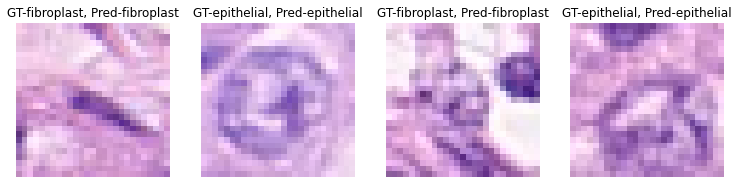

In [91]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')